# MACHINE LEARNING

Desired output of the turbine: 
- rotor torque
- converter torque
- power output

Only Active Power (P_avg) and Rotor Torque (Rm_avg) are availeble. 

The list of features used for learning is:
```[ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg']```

### 1. Create a set of pipelines & define a parameter grid to optimize kernels

- Linear
- Polynomial
- Kernel Ridge Regression

### 2. Compare the different models, once optimized, versus the size of the database


- **Prediction Accuracy**: 

| Metric    | Linear             | Polynomial         | Kernel             |
|-----------|--------------------|--------------------|--------------------|
| MAE       | 123.83655569129044 | 26.563523071212337 | 18.069286899183126 |
| RMSE      | 28737.204834443808 | 2105.0001314111532 | 1699.991079011466  |
| R-squared | 0.8546457205691437 | 0.9895920141194349 | 0.9912831790974509 |


- **Model Training Time**: 

| Metric              | Linear | Polynomial | Kernel  |
|---------------------|--------|------------|---------|
| Model Training Time | 752 ms | 939 ms     | 5min 2s |


### 3. Consider the contribution of 'enriched variables'

- Adding ```['rain_1h', 'snow_1h', 'humidity']``` to the descriptor does not improve the system prediction accuracy.

### Conclusion

- Wind speed, Rotor speed, Nacelle temperature and Pitch angle are enough to build a Machine Learning Model
- Kernel models are notably heavy in memory, especially KRR ~O(N^2). This limitation imposed me to limit the training on 20000 entries

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

from windml.core.functions import load_one

data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
turbine_name = 'R80711'
turbine_csv_file = Path(data_dir, f'{turbine_name}.csv')

df = load_one(turbine_csv_file)
df = df.sample(20000)

Loading time: 1.30 seconds.
Memory usage: 65.67 MB.
261812 Lines found.
time: 8.52 s (started: 2024-04-12 00:26:58 +02:00)


In [2]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg' ]

scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'

time: 388 µs (started: 2024-04-12 00:27:07 +02:00)


In [3]:
from sklearn.model_selection import train_test_split
from windml.visualization.custom_plots import scatter_plot

time: 421 ms (started: 2024-04-12 00:27:07 +02:00)


In [4]:
# Separating the target variable 'y' and features 'X'

X = df[x_list] # take most correlated variables
y = df[y_variable].values.reshape(-1, 1)

# Split the dataset into training and testing sets (20% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time: 40.2 ms (started: 2024-04-12 00:27:07 +02:00)


# Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'regressor__fit_intercept': True}
Best score (neg_mean_absolute_error): -126.49314121404912


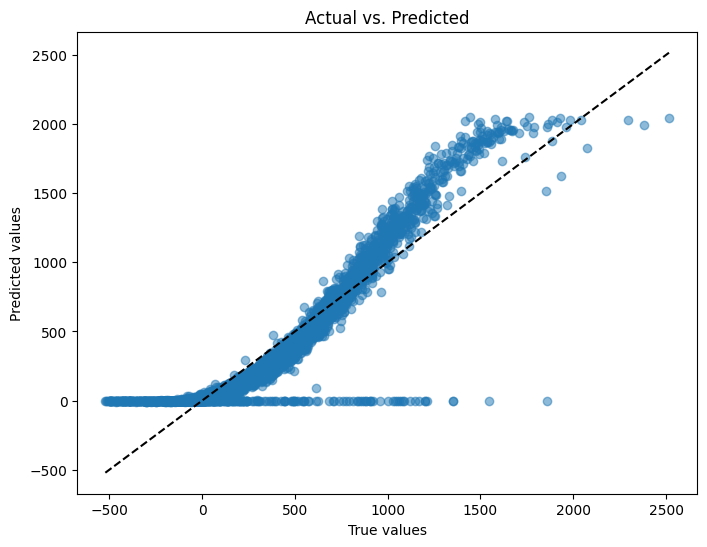

time: 721 ms (started: 2024-04-12 00:27:07 +02:00)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Set up the pipeline with a single step: the linear regression model
lin_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Define the parameter grid to search over
lin_param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV with the pipeline and the parameter grid
lin_grid_search = GridSearchCV(lin_pipeline, lin_param_grid, cv=5, scoring=scoring, verbose=1)

# Fit the GridSearchCV to the training data
lin_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", lin_grid_search.best_params_)
print(f"Best score ({scoring}):", lin_grid_search.best_score_)

# Predictions
y_pred = lin_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# Polynomial Regression

Best parameters: {'poly_features__degree': 3, 'regressor__fit_intercept': False}
Best score (neg_mean_absolute_error): -25.405487937497263


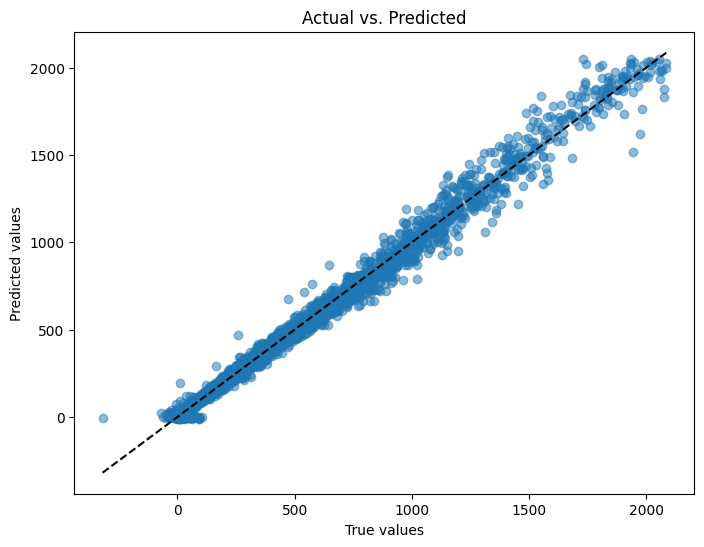

time: 715 ms (started: 2024-04-12 00:27:08 +02:00)


In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Set up the pipeline
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameter grid
poly_param_grid = {
    'poly_features__degree': [1, 2, 3],  
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV
poly_grid_search = GridSearchCV(poly_pipeline, poly_param_grid, cv=5, scoring=scoring)

# Fit
poly_grid_search.fit(X_train, y_train)

# Print best score
print("Best parameters:", poly_grid_search.best_params_)
print(f"Best score ({scoring}):", poly_grid_search.best_score_)

# Predictions
y_pred = poly_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# KERNEL RIDGE REGRESSION

### Laplacian (L1) vs Gaussian (L2 or RBF) Kernel
$$ K_{L1}(x, x') = \exp\left(-\gamma \|x - x'\|\right) $$
$$ K_{L2}(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

### Kernel Ridge Regression (KRR)
Kernel Ridge Regression combines Ridge Regression (linear least squares with L2-norm regularization) with the kernel trick. The objective function for KRR is:

$$ \min_{w} \|Xw - y\|^2 + \alpha \|w\|^2 $$

Where:
- $X$ is the matrix of input features.
- $w$ is the vector of coefficients.
- $y$ is the vector of target values.
- $\alpha$ is the regularization parameter.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'regressor__alpha': 0.01, 'regressor__gamma': 1, 'regressor__kernel': 'rbf'}
Best score (neg_mean_absolute_error): -16.46194966972685


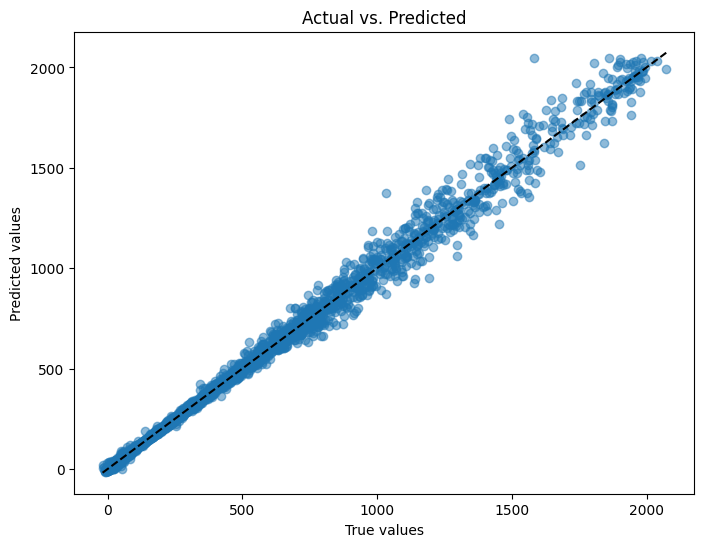

time: 20min 45s (started: 2024-04-12 00:27:09 +02:00)


In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

# Set up the pipeline
krr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional but recommended
    ('regressor', KernelRidge())
])

# Define the parameter grid
krr_param_grid = {
    'regressor__kernel': ['rbf'], #, 'manhattan_distances' -> gives awful results
    'regressor__alpha': [1e-4, 1e-2, 1],
    'regressor__gamma': [1e-4, 1e-2, 1],
}

# Initialize GridSearchCV with the pipeline and parameter grid
krr_grid_search = GridSearchCV(krr_pipeline, krr_param_grid, cv=5, scoring=scoring, verbose=1)

# Fit GridSearchCV to the training data
krr_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", krr_grid_search.best_params_)
print(f"Best score ({scoring}):", krr_grid_search.best_score_)

# Predictions
y_pred = krr_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# Learning Curve

In [8]:
from windml.machine_learning.regression_models import learning_curve

# Generate learning curve data without GridSearchCV
lin_LC = learning_curve(df, x_list, y_variable, lin_grid_search )
ploy_LC = learning_curve(df, x_list, y_variable, poly_grid_search )
krr_LC = learning_curve(df, x_list, y_variable, krr_grid_search )

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 10, MAE: 33.662573818337336
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 35, MAE: 63.055931672849134
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 125, MAE: 157.09696264303088
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 447, MAE: 122.78217062494471
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 1587, MAE: 116.53883739330408
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 5634, MAE: 124.81277105078827
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Subset size: 20000, MAE: 129.1215079980234
Subset size: 10, MAE: 64.63257756983248
Subset size: 35, MAE: 178.68754483976585
Subset size: 125, MAE: 44.550151934980256
Subset size: 447, MAE: 23.502587364668564
Subset size: 1587, MAE: 24.820518615333178
Subset size: 5634, MAE: 25.257082694567313
Subset size: 20000, MAE: 26.482791

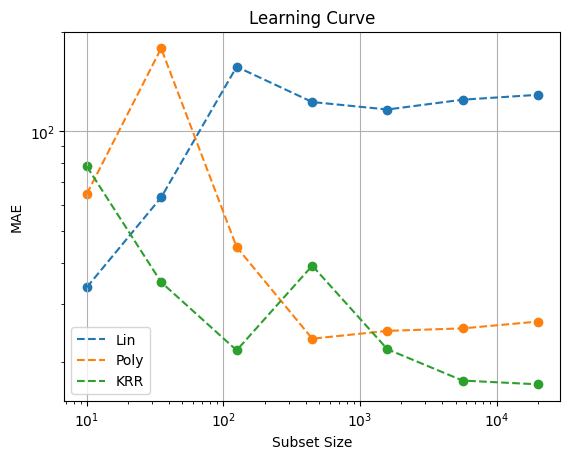

time: 721 ms (started: 2024-04-12 01:10:51 +02:00)


In [10]:
fig, ax = plt.subplots()
for (lc_data, lc_name) in [(lin_LC, 'Lin'),
                            (ploy_LC, 'Poly'),
                            (krr_LC, 'KRR')]:
    subset_sizes = list(lc_data.keys())
    errors = [lc_data[size]['mae'] for size in subset_sizes]
    ax.scatter(subset_sizes, errors)
    ax.loglog(subset_sizes, errors, label=lc_name, linestyle='--')
    
plt.xlabel('Subset Size')
plt.ylabel(f'MAE')
plt.title('Learning Curve')
plt.xscale('log')
plt.grid(True)

plt.legend()
plt.savefig('learning_curve.jpeg')

# Polynomial regression with enriched data

In [11]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg', 'rain_1h', 'snow_1h', 'humidity' ]

enriched_ploy_LC = learning_curve(df, x_list, y_variable, poly_grid_search )

Subset size: 10, MAE: 369.09409905285554
Subset size: 35, MAE: 599.4772238794056
Subset size: 125, MAE: 92.3175767375203
Subset size: 447, MAE: 34.514867877800704
Subset size: 1587, MAE: 31.432372373120753
Subset size: 5634, MAE: 26.764225881443828
Subset size: 20000, MAE: 24.758019035434693
time: 3.18 s (started: 2024-04-12 01:10:51 +02:00)


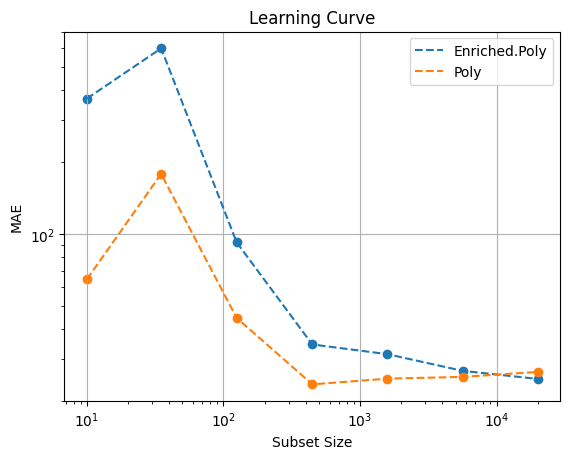

time: 745 ms (started: 2024-04-12 01:10:54 +02:00)


In [12]:
# Plotting the learning curve
fig, ax = plt.subplots()
for (lc_data, lc_name) in [(enriched_ploy_LC, 'Enriched.Poly'),
                            (ploy_LC, 'Poly'),
                          ]:
    subset_sizes = list(lc_data.keys())
    errors = [lc_data[size]['mae'] for size in subset_sizes]
    ax.scatter(subset_sizes, errors)
    ax.loglog(subset_sizes, errors, label=lc_name, linestyle='--')
    
plt.xlabel('Subset Size')
plt.ylabel(f'MAE')
plt.title('Learning Curve')
plt.xscale('log')
plt.grid(True)

plt.legend()
plt.savefig('learning_curve_enriched.jpeg')